# Machine Learning 2024-2025 - UMONS

# Tree-Based Methods

In this lab, our objective is to predict whether female patients suffer from diabetes based on a series of medical attributes. To do so, we will apply several tree-based methods to the [Pima Indians diabetes dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database): "The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage".

Here is a description of the dataset's attributes:
  - **Num_pregnant**: The number of pregnancies the patient had. 
  - **glucose_con**: Patient's plasma glucose concentration.
  - **blood_pressure**: Patient's diastolic blood pressure ($\mathrm{mmHg}$).
  - **triceps_thickness**: Patient's triceps skin-fold thickness ($\mathrm{mm}$).
  - **insulin**: Patient's 2-hour serum insulin ($\mathrm{\mu U/mL}$).
  - **bmi**: Patient's body mass index ($\mathrm{kg/m^2}$).
  - **dpf**: Patient's diabetes pedigree function.
  - **age**: Patient's age (years). 
  - **diabetes**: Whether the patient has diabetes ($1$) or not ($0$).

**Load the necessary libraries.** 

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import math
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, BaggingClassifier, BaggingRegressor
from sklearn.utils import resample

**1) Load the dataset, get its general information, and check for missing values.** 

In [2]:
file = 'data/pima_indians_lab.csv'
df = pd.read_csv(file, index_col=0)
print(df.info())
print(df.head())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Num_pregnant       750 non-null    float64
 1   glucose_con        755 non-null    float64
 2   blood_pressure     761 non-null    float64
 3   triceps_thickness  757 non-null    float64
 4   insulin            768 non-null    float64
 5   bmi                768 non-null    float64
 6   dpf                767 non-null    float64
 7   age                761 non-null    float64
 8   diabetes           768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 60.0 KB
None
   Num_pregnant  glucose_con  blood_pressure  triceps_thickness  insulin  \
0           6.0        148.0            72.0               35.0      0.0   
1           1.0         85.0            66.0               29.0      0.0   
2           8.0        183.0            64.0                0.0      0.0   
3           1

# Decision Trees

**2) Select `diabetes` as the target variable, and all the remaining columns as predictors.**

**Create a pipeline containing the preprocessing steps (missing values imputer, scaler...) and a `DecisionTreeClassifier` with a maximum depth set to $3$ (through the `max_depth` argument). Use the entropy as split criterion.** 
- **Do you think scaling the variables is necessary?**


**Fit this pipeline to the data (do not split the dataset for the time being), and plot the decision tree. How do you interpret it?** 

**You will need the `plot_tree` method from the `sklearn` library. You can access the pipeline's classifier using the `named_steps['classifier']` attributes. You will also need to pass the features' (predictors) names to the function using the `features_names` argument.**

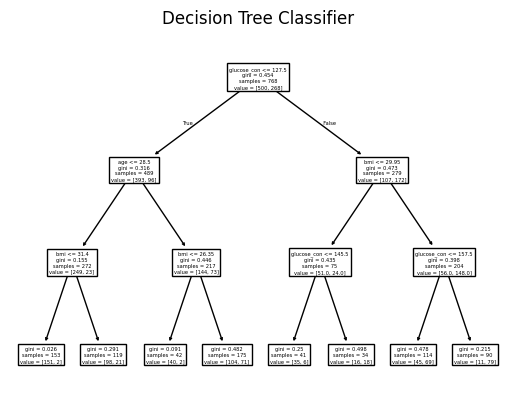

In [18]:
X =   df.drop(columns=['diabetes'],axis=1)
y =   df[['diabetes']]

# Impute missing values
preprocessor = SimpleImputer(strategy='mean')

# Create a pipeline with the preprocessor and the classifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))
])
# Fit the pipeline
pipe.fit(X, y)
tree = pipe.named_steps['classifier']
plot_tree(tree,
          feature_names=X.columns)
plt.title('Decision Tree Classifier')
plt.savefig('decision_tree_classifier.png')
plt.show()

pas forcément besoin de scaler les données

**3) Let us see how the model's performance evolve as a function of the tree's maximum depth.**

**To this end, apply the following steps:**
- **Split the dataset into a training and a test set following a $80\%$/$20\%$ partition.**
- **For maximum depths varying from $1$ to $20$, fit a `DecisionTreeClassifier` to the *training* data using $10$-fold cross-validation with the area under the ROC curve (abbreviated AUC or AUROC) as metric.**
- **Plot the means of the training and validation AUROCs across each fold as a function of the maximum depth.**
- **Assuming independence of the AUROCs, what is the formula for the standard error of the means at each depth? Compute an estimation of it and add it to the plot as a shaded grey area around the means (you can use [`fill_between`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) for this).**
    - **What can you conclude regarding the model's performance, as well as the uncertainty for the in-sample and out-of-sample AUROC estimates?**
- **Identify which depth would lead a priori to the best model's out-of-sample performance. Using this depth, fit a decision tree to the training split and report the training AUROC and the test AUROC.** 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
for depth in range(1,21):


Clearly, the decision tree starts overfitting very early as the maximum depth increases, as shown by the increasing gap between the training and test curves. 

The in-sample variance of a classifier quantifies by how much its predictions on the training data will vary when it is fitted on different training sets. This is precisely what happens during cross-validation, as the same classifier's architecture is trained on different training sets, resulting in different models. The better the model fits the training data, the less error it makes when evaluated on it. This explains why the standard error is small for the training AUROC. In each fold, the model overfits the training data, and hence, its predictions do not vary much across folds. It goes up to the point where the model is complex enough to perfectly interpolate the training data (i.e., the model does not make any mistake on the training data). As in this case the training AUROC is equal to $1$ in each fold, the standard error is null. 

On the other hand, the out-of-sample standard error is larger, and increases when overfitting happens. Indeed, as the models (in a $10$-fold cross-validation, we have $10$ different models) are extremely specific to the data they have been trained on, their predictions vary significantly when presented to unseen data (the validation fold), resulting in a high variance of validation AUROCs across the different folds, and hence, a large standard error.

# Bagging 

**4) Implement your own bagging algorithm by fitting a decision tree to each bootstrap sample. To this end, perform the following steps:**
- **Draw $30$ bootstrap samples from the training set with replacement. Each bootstrap sample should contain the same number of observations as in the training set. Use the `resample()` method of scikit-learn.** 
- **For each bootstrap sample:**
  - **Fit a `DecisionTreeClassifier` to the bootstrap sample. Reuse the pipeline defined previously. The maximum depth of each tree should be fixed to $5$.**
  - **Using the fitted decision tree, predict the class and the probabilities on the test set, and save them in a list.**
- **You will now use two different aggregation strategies to get a single prediction from the ensemble:** 
  - **Majority vote strategy: predict the class that was predicted the most by each tree separately.**
  - **Average probability strategy: predict the class whose average probability across each tree is the highest.** 
- **Plot the confusion matrix of the predictions for both aggregation strategies separately.**

# Random Forests

**5) Perform a `RandomizedSearchCV` on a specified grid of hyper-parameters to find the best configuration for a `RandomForestClassifier`. Set the scoring function as the AUROC and limit the number of combinations to try to $10$.**

**Fit the best model found in the previous procedure to the training data, and predict on the test set. Report the test AUROC and display the ROC curve.**

# Boosting

**7) Fit a `GradientBoostingClassifier` to the training data, and report the training and test AUROCs.**

**8) For a `DecisionTreeClassifier`, a `BaggingClassifier`, a `RandomForestClassifier`, and a `GradientBoostingClassifier`, perform a `RandomizedSearchCV` on a predefined grid of hyper-parameters (you may modify them as you wish). Amongst all models and hyper-parameters combinations, select the best model and report the best *validation* AUROC. The random search should be performed on the *training* data, and you can set the number of combinations to try per model to $5$.**

**For the best model found, report the training and test AUROCs, and display the training and test ROC curves.**

In [ ]:
param_grid_boost = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__learning_rate' : [0.5,0.1,0.05],
    'classifier__min_samples_split' : [2,5,10],
    'classifier__min_samples_leaf' : [2,5,10]
}

param_grid_bag = {
    'classifier__n_estimators' : [25,50,100,150,200],
}

param_grid_tree = {
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [None,2,5,10],
    'classifier__min_samples_split' : [2,5,10],
    'classifier__min_samples_leaf' : [2,5,10]
}

param_grid_forest = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [5,10,15,20,None],
    'classifier__max_features' : ['sqrt', 'log2']
}

# Regression 

**9) Select *bmi* as the target variable and all the remaining columns in the dataframe as the predictors, at the exception of *diabetes*. Split your dataset into a training and test set, fit a `DecisionTreeRegressor` to the training data, and report the MSE on the training and test sets. What do you observe?**

As we did not impose any restrictions on the depth that the tree could reach, it grew to the point that each leaf contains a single training observation. The value predicted for a leaf being the mean of the observations contained in it, and as each leaf contains a single observation, the model exactly predicts all training points, and the training MSE is $0$. The behavior obviously does not generalize well, as shown by the test MSE. 

**10) For a `DecisionTreeRegressor`, a `BaggingRegressor`, a `RandomForestRegressor`, and a `GradientBoostingRegressor`, perform a `RandomizedSearchCV` on a predefined grid of hyper-parameters. Amongst all models and hyper-parameters combinations, select the best model and report the best *validation* MSE. The random search should be performed on the *training* data, and you can set the number of combinations to try per model to $5$.**

**For the best model found, report the training and test MSE.**

In [ ]:
param_grid_boost = {
    'regressor__n_estimators' : [50,100,150,200],
    'regressor__learning_rate' : [0.5, 0.1, 0.05],
    'regressor__min_samples_split' : [2,5,10],
    'regressor__min_samples_leaf' : [2,5,10]
}

param_grid_bag = {
    'regressor__n_estimators' : [25,50,100,150,200],
}

param_grid_tree = {
    'regressor__criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'regressor__max_depth' : [None, 2,5,10],
    'regressor__min_samples_split' : [2,5,10],
    'regressor__min_samples_leaf' : [2,5,10]
}

param_grid_forest = {
    'regressor__n_estimators' : [50,100,150,200],
    'regressor__criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'regressor__max_depth' : [5,10,15,20,None],
    'regressor__max_features' : ['sqrt', 'log2']
}